# Convolutional Neural Networks using Tensorflow and Keras

We will work through creating a convolutional neural network from scratch.

## Step 1 - Import the data

We will use `image_dataset_from_directory` to build our training and validation sets. This function expects our images to be in folders separated by class, and the classifcation values are inferred from the folder names.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# You can mess with batch size
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)
SEED = 1

# This sets up a training and validation set from our ../data/ directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=SEED)

# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
val_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    validation_split=0.2,
    subset='validation',
    seed=SEED)

Found 1469 files belonging to 2 classes.
Using 1176 files for training.
Found 1469 files belonging to 2 classes.
Using 293 files for validation.


## Step 2 - Set up the image augmentation and preprocessing

This [tutorial](https://www.tensorflow.org/guide/keras/preprocessing_layers) provides some of the preprocessing and image augmentation option using Keras layers. We will be integrating the preprocessing and augmentation into our model, which streamlines the process and makes the model more portable. But the tutorial also presents an alternate way that may be more efficient if you are training using your CPU (which we are unless you do some extra setup to utilize a GPU).

You can experiment with some of the other image augmentation layers such as:
* tf.keras.layers.RandomCrop
* tf.keras.layers.RandomFlip
* tf.keras.layers.RandomTranslation
* tf.keras.layers.RandomRotation
* tf.keras.layers.RandomZoom
* tf.keras.layers.RandomContrast

We will also be applying some preprocessing to rescale the images to have color values in [0,1] instead of [0,255] and to crop/resize the images down to (224,224). We don't need the cropping for the images that we processed last class period, but this will allow us to use our model on any size image without worrying about processing it first.

In [2]:
from tensorflow.keras import layers

image_preprocess = tf.keras.Sequential([
    tf.keras.Input((None,None,3)),
    layers.Resizing(224,224, crop_to_aspect_ratio = True),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

image_preprocess.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Test out our image augmentation:

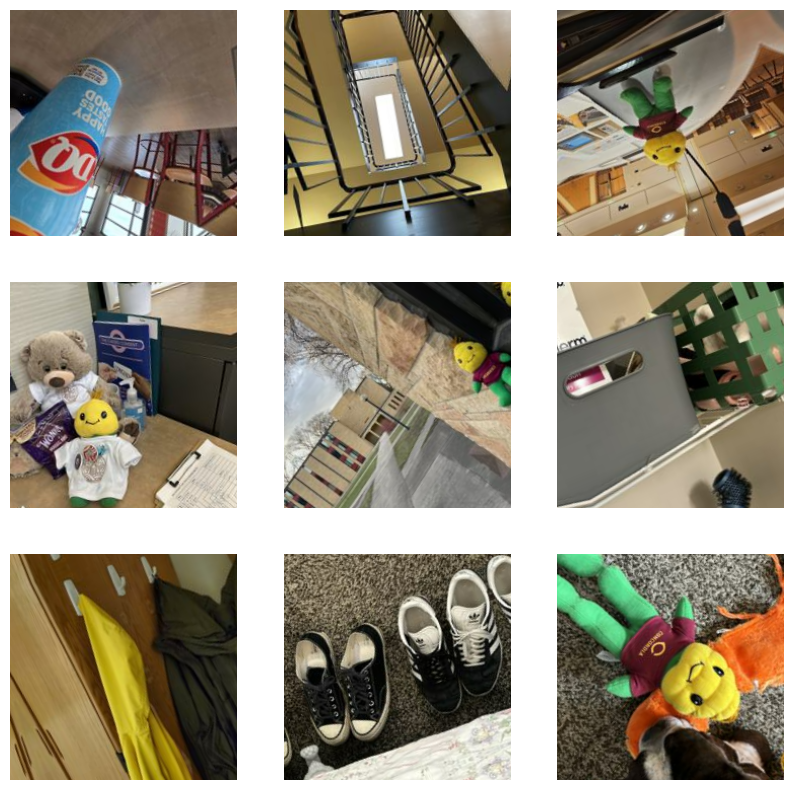

In [3]:
iterator = iter(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
  image = tf.cast(tf.expand_dims(next(iterator)[0][0], 0), tf.float32)
  augmented_image = image_preprocess(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Step 3 - Sequential Layers

The main layers we will use are:
* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) - Convolutional layer
* [AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) - Pooling layers
* [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) - After all the convolutions are done, this flattens the 2D image to a vector.
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) - Fully connected layer
* [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - Randomly masks a portion of the previous layer during training.

You can experiment with the parameters in these layers.

In [4]:
nnet_layers = tf.keras.Sequential([
    tf.keras.Input((224,224,3)),
    layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
])

nnet_layers.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 4)         │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 8)         │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,639,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Put the model together:

In [5]:
inputs = tf.keras.Input(shape=(None,None, 3))
x = image_preprocess(inputs)
outputs = nnet_layers(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │       1,729,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model:

In [6]:
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

## Step 4 - Train the Model

Time for some popcorn

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=50, monitor='val_loss')

history = model.fit(train_dataset, epochs=1000,
                    validation_data=val_dataset,
                    callbacks=[es])

Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9791 - loss: 0.0480 - val_accuracy: 0.9352 - val_loss: 0.2436
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9800 - loss: 0.0532 - val_accuracy: 0.9590 - val_loss: 0.1164
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9735 - loss: 0.0953 - val_accuracy: 0.9352 - val_loss: 0.1697
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9793 - loss: 0.0599 - val_accuracy: 0.9488 - val_loss: 0.2006
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9736 - loss: 0.0706 - val_accuracy: 0.9454 - val_loss: 0.1774
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9684 - loss: 0.0846 - val_accuracy: 0.9659 - val_loss: 0.1039
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9772 - loss: 0.0746 - val_accuracy: 0.9454 - val_loss: 0.1466
Epoch 8/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9710 - loss: 0.0728 - val_accu

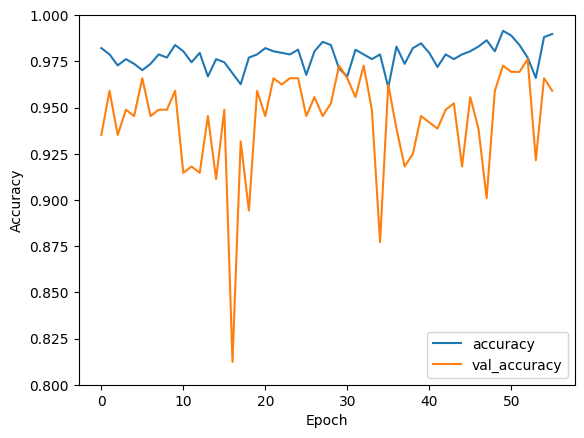

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

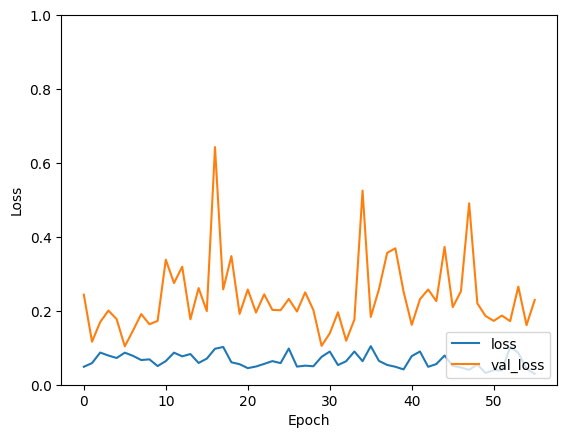

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

## Step 5 - Save the model

If you like your model, then save your model.

In [19]:
model.save('../models/model_gt_2024_04_20.keras')

Later on, you can reload the model with:

In [ ]:
# model = tf.keras.models.load_model('../models/model_gt_2024_04_20.keras')

## Step 6 - Assess the model

Let's test the model on some new data. 

The `test` folder contains several subdirectories:
* `all` - All Niblet and not-Niblet images
* `test_niblet_alone` - Images of Niblet alone against a white backdrop
* `test_niblet_noshirt` - Images of Niblet alone against a white backdrop without Niblet's maroon shirt
* `test_niblet_others` - Images of Niblet with other stuffed toys against a white backdrop
* `test_niblet_natural` - Images of Niblet in natrual photos
* `test_not_niblet_alone` - Images of not-Niblet stuffed toys alone against a white backdrop
* `test_not_niblet_shirt` - Images of not-Niblet stuffed toys alone against a white backdrop wearing Niblet's maroon shirt
* `test_not_niblet_others` - Images of not-Niblet with other stuffed toys against a white backdrop
* `test_not_niblet_natural` - Images of not-Niblet in natural photos

### Test 1 - Images of Niblet alone against a white backdrop

In [96]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/test_niblet_alone/',
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=False,
    seed=SEED)

test_iterator = iter(test_set)
test_batch = next(test_iterator)

Found 25 files belonging to 1 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


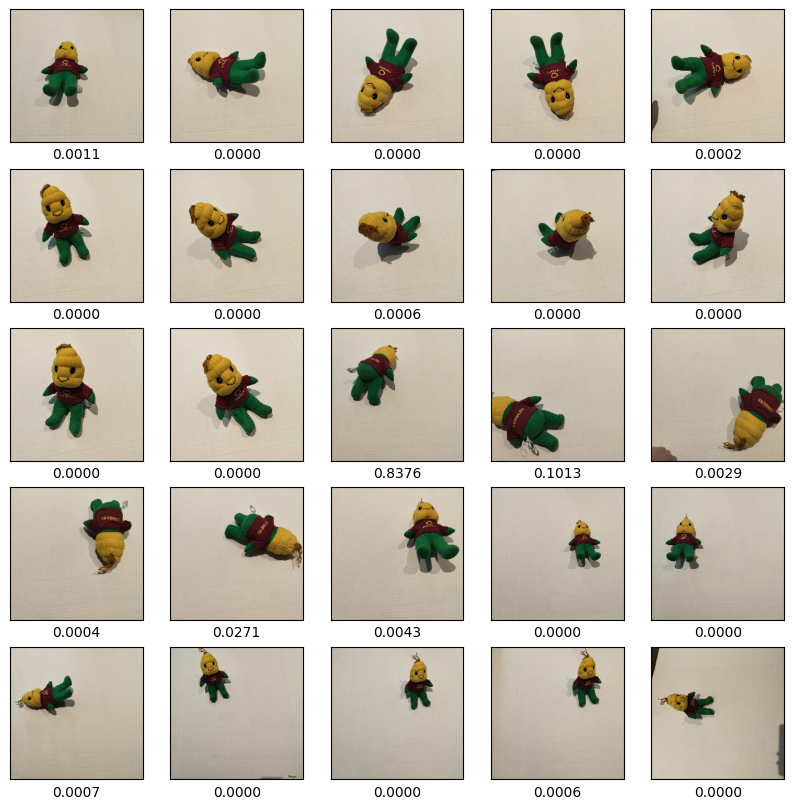

In [97]:
predictions = model.predict(test_set)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[0][i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

In [98]:
model.evaluate(test_set, return_dict = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9600 - loss: 0.0785


{'accuracy': 0.9599999785423279, 'loss': 0.07850806415081024}

### Test 2 - Images of not-Niblet stuffed toys alone against a white backdrop

In [99]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/test_not_niblet_alone/',
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=False,
    seed=SEED)

test_iterator = iter(test_set)
test_batch = next(test_iterator)

Found 50 files belonging to 1 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


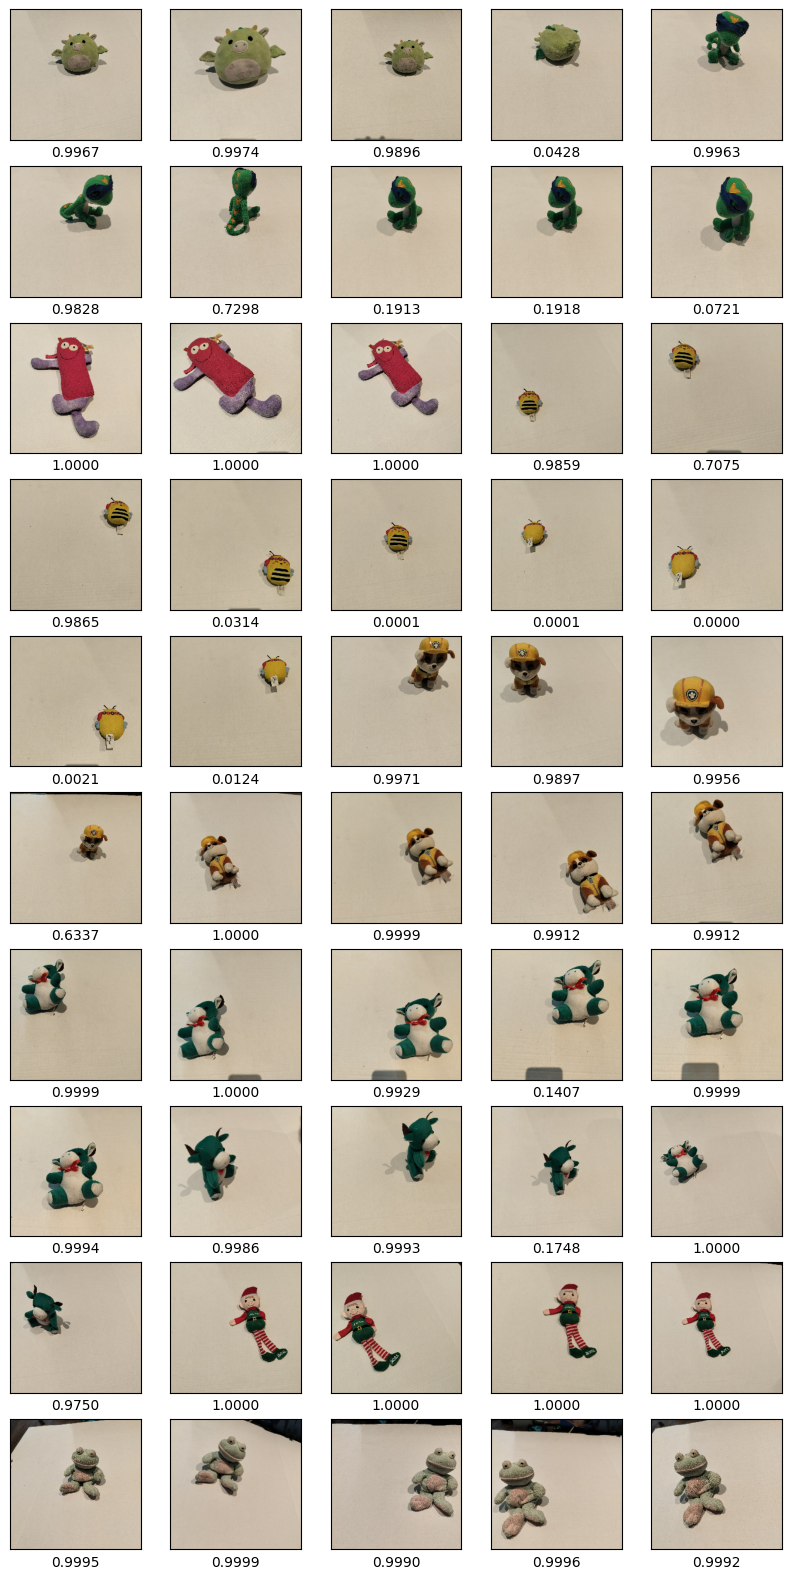

In [107]:
predictions = model.predict(test_set)

plt.figure(figsize=(10,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[0][i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

In [109]:
model.evaluate(test_set, return_dict = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 0.2400 - loss: 6.9651


{'accuracy': 0.23999999463558197, 'loss': 6.9651408195495605}

### Test 3 - All images

In [110]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/all/',
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=False,
    seed=SEED)

test_iterator = iter(test_set)
test_batch = next(test_iterator)

Found 192 files belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


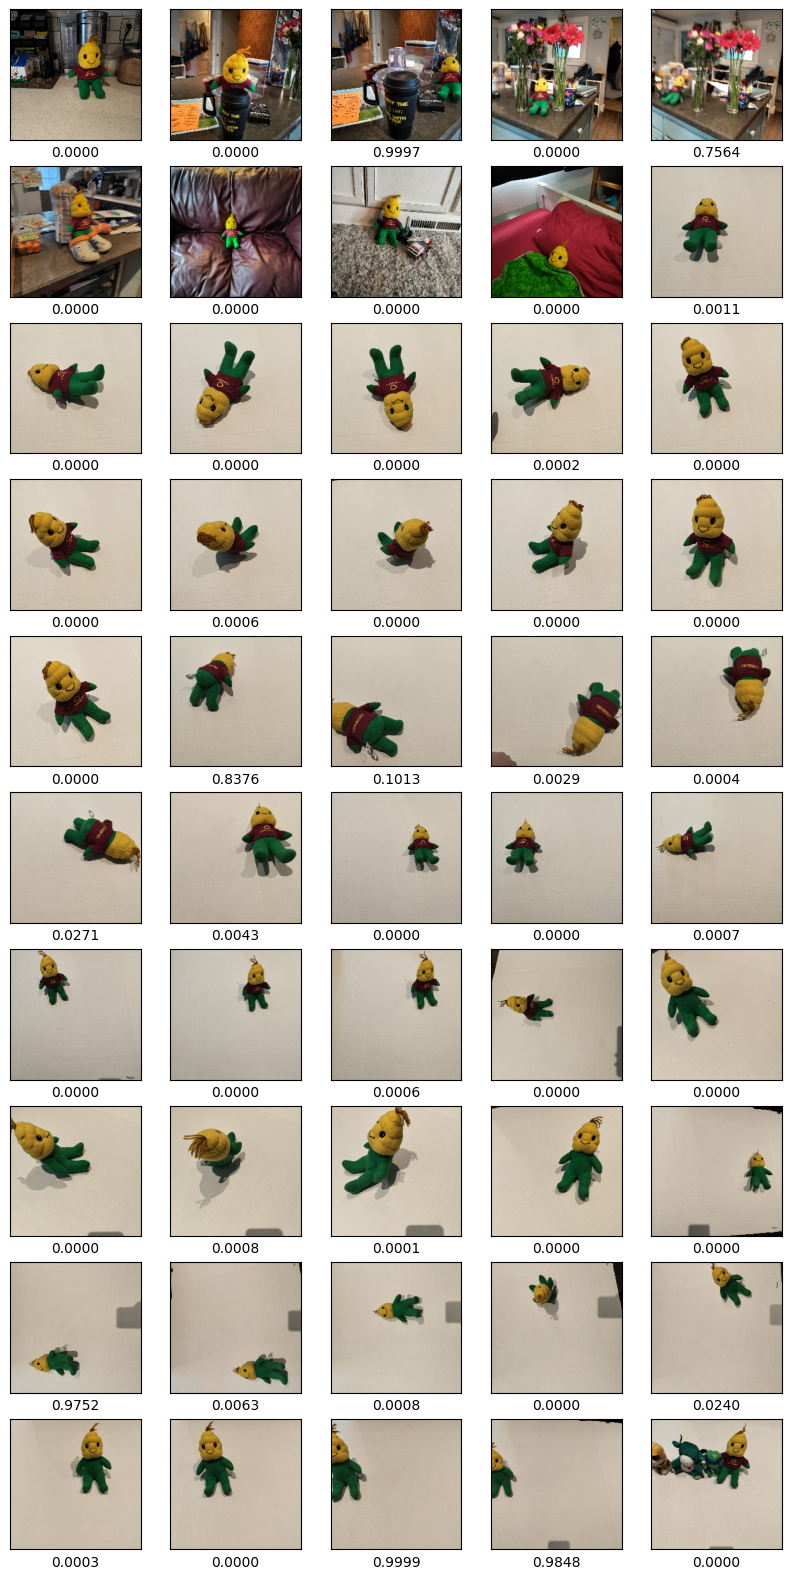

In [111]:
predictions = model.predict(test_set)

plt.figure(figsize=(10,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[0][i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

In [112]:
model.evaluate(test_set, return_dict = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7656 - loss: 1.1818


{'accuracy': 0.765625, 'loss': 1.181810736656189}